In [1]:
import rqalpha as rqa
import rqalpha_plus
import rqoptimizer as rqo
import rqdatac as rqd
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pickle
import os

In [2]:
rqd.init()

In [3]:
def get_best_size_fund(date,lower_limit,upper_limit):
    """获取某天基金规模在一定范围内的混合型和股票型基金代码"""
    fund_df = rqd.fund.all_instruments(date=date)
    fund_df = fund_df[fund_df['fund_type'].isin(['Hybrid','Stock'])].dropna()
    # 取规模在20-100亿之间的基金
    fund_df = fund_df[(fund_df['latest_size']>lower_limit) & (fund_df['latest_size']<upper_limit)]
    return fund_df['order_book_id'].tolist()

def get_best_profit_fund(fund_list,start_date,end_date,ratio):
    """获取基金业绩前10%的基金"""
    net_value_df = rqd.fund.get_nav(fund_list, start_date=start_date, end_date=end_date,expect_df=True)
    return_df = net_value_df.groupby(level=0).apply(lambda x:x.iloc[-1]/x.iloc[0]-1)
    n = int(return_df.shape[0]*ratio)
    return return_df.nlargest(n,'unit_net_value').index.tolist()

def get_target_portfolio(best_fund,date,nlargest,method,benchmark):
    """获得业绩最好的基金重仓股"""
    holdings_df = rqd.fund.get_holdings(best_fund, date=date)
    holdings_df = holdings_df[holdings_df['type']=='Stock']
    holdings_df = holdings_df.droplevel(1)[['order_book_id','weight']]
    # 获得每个基金前权重股
    max_weight_holdings = holdings_df.groupby(level=0).apply(lambda x:x.nlargest(nlargest,'weight'))
    if method == 'tracking_error':
        universe = np.unique(max_weight_holdings['order_book_id'].values)
        target_portfolio = rqo.portfolio_optimize(
            universe, date, rqo.MinTrackingError(),benchmark=benchmark
        )
    return target_portfolio.loc[lambda x: x != 0]

In [4]:
def init(context):
    pass

def handle_bar(context, bar_dict):
    # 如果是False(不是月初),直接返回
    if not _should_rebalance(context):
        return
    start_date = context.now-timedelta(365)
    end_date = context.now
    best_size = get_best_size_fund(context.now,context.lower_limit,context.upper_limit)
    best_profit = get_best_profit_fund(best_size,start_date,end_date,context.ratio)
    context.target_portfolio = get_target_portfolio(best_profit,context.now,**context.portfolio_args)
    rebalance(context, bar_dict)
    print("现有持仓数:", len(context.portfolio.positions))


def _should_rebalance(context):
    """判断今天是否调仓"""
    # 获得下一个交易日
    pre_trading_day = rqd.get_previous_trading_date(context.now)
    # 判断是否是月初, 是月初返回True
    is_rebalance = (pre_trading_day.month != context.now.month) and (context.now.month in [4,7,10,1])
    return is_rebalance


def rebalance(context, bar_dict):
    positions = context.portfolio.positions
    for order_book_id in positions:
        if order_book_id not in context.target_portfolio:
            rqa.api.order_to(order_book_id, 0)
    
    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.portfolio.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}
    _money_for_one_lot = lambda order_book_id: bar_dict[order_book_id].close * 100
    for order_book_id, weight in context.target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap)<_money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # to avoid liquidity issue, sell first, buy second
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)

In [8]:
MILLION = 1_000_000
BILLION = 1000 * MILLION
benchmark = '000300.XSHG'
config = {
    "base": {
        "start_date": '2014-03-31',
        "end_date": '2020-09-02',
        "frequency": '1d',
        "accounts": {"stock": 0.1 * BILLION},
        "data_bundle_path":r'C:\Users\Administrator\.rqalpha-plus\bundle'
    },
    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": benchmark,
        },
        'sys_simulation': {
            # 撮合时无视涨跌停
            'price_limit': False,
        },
        'sys_risk': {
            'enabled': True,
            # 发单时无视停牌
            'validate_is_trading': False,
            # 发单时无视涨跌停
            'validate_price': False
        },
    },
    "extra": {
        "log_level": 'error',
        "context_vars": {
            'cash_cushion': 0.005,
            'lower_limit': 2e9,
            'upper_limit':1e10,
            'ratio':0.2,
            'portfolio_args':{
                'nlargest':10,
                'method':'tracking_error',
                'benchmark':benchmark
            }
        },
    },
}

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


WARN: aa_init returned NULL, no acceleration applied.


[2014-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 122


WARN: aa_init returned NULL, no acceleration applied.


[2014-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 198


WARN: aa_init returned NULL, no acceleration applied.


[2014-10-08 15:00:00.000000] INFO: user_log: 现有持仓数: 252


WARN: aa_init returned NULL, no acceleration applied.


[2015-01-05 15:00:00.000000] INFO: user_log: 现有持仓数: 257


WARN: aa_init returned NULL, no acceleration applied.


[2015-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 244


WARN: aa_init returned NULL, no acceleration applied.


[2015-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 246


WARN: aa_init returned NULL, no acceleration applied.


[2015-10-08 15:00:00.000000] INFO: user_log: 现有持仓数: 272


WARN: aa_init returned NULL, no acceleration applied.


[2016-01-04 15:00:00.000000] INFO: user_log: 现有持仓数: 282
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 603798.XSHG 在 2016-04-01 尚未上市，被剔除
  self._handle_bar(self._user_context, bar_dict)


WARN: aa_init returned NULL, no acceleration applied.


[2016-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 335


WARN: aa_init returned NULL, no acceleration applied.


[2016-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 353


WARN: aa_init returned NULL, no acceleration applied.


[2016-10-10 15:00:00.000000] INFO: user_log: 现有持仓数: 389


WARN: aa_init returned NULL, no acceleration applied.


[2017-01-03 15:00:00.000000] INFO: user_log: 现有持仓数: 393


WARN: aa_init returned NULL, no acceleration applied.


[2017-04-05 15:00:00.000000] INFO: user_log: 现有持仓数: 348
[2017-07-03 15:00:00.000000] INFO: user_log: 现有持仓数: 278


WARN: aa_init returned NULL, no acceleration applied.


[2017-10-09 15:00:00.000000] INFO: user_log: 现有持仓数: 239


WARN: aa_init returned NULL, no acceleration applied.


[2018-01-02 15:00:00.000000] INFO: user_log: 现有持仓数: 226


WARN: aa_init returned NULL, no acceleration applied.


[2018-04-02 15:00:00.000000] INFO: user_log: 现有持仓数: 219


WARN: aa_init returned NULL, no acceleration applied.


[2018-07-02 15:00:00.000000] INFO: user_log: 现有持仓数: 204


WARN: aa_init returned NULL, no acceleration applied.


[2018-10-08 15:00:00.000000] INFO: user_log: 现有持仓数: 205


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\core\strategy.py:92: OptimizerWarning: 600270.XSHG 在 2019-01-02 时已退市，被剔除
  self._handle_bar(self._user_context, bar_dict)
[2019-01-02 15:00:00.000000] INFO: user_log: 现有持仓数: 234


WARN: aa_init returned NULL, no acceleration applied.


[2019-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 268


WARN: aa_init returned NULL, no acceleration applied.


[2019-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 250


WARN: aa_init returned NULL, no acceleration applied.


[2019-10-08 15:00:00.000000] INFO: user_log: 现有持仓数: 226


WARN: aa_init returned NULL, no acceleration applied.


[2020-01-02 15:00:00.000000] INFO: user_log: 现有持仓数: 222


WARN: aa_init returned NULL, no acceleration applied.


[2020-04-01 15:00:00.000000] INFO: user_log: 现有持仓数: 231


WARN: aa_init returned NULL, no acceleration applied.


[2020-07-01 15:00:00.000000] INFO: user_log: 现有持仓数: 247


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\mod\rqalpha_mod_sys_analyser\plot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


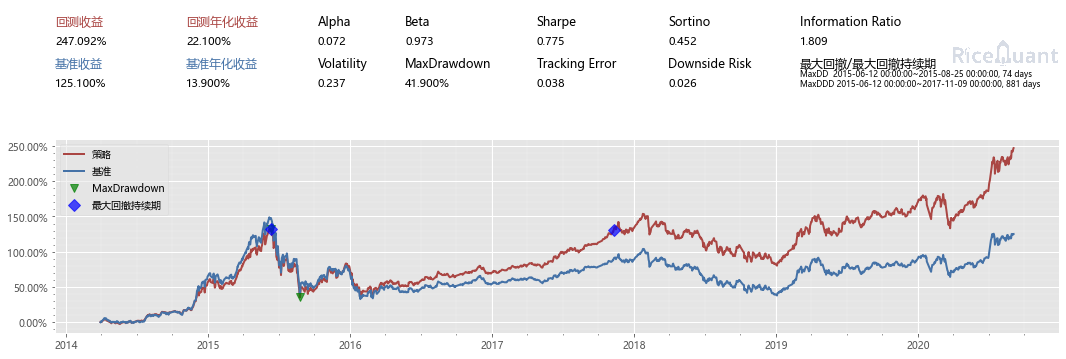

In [9]:
result = rqalpha_plus.run_func(init=init,handle_bar=handle_bar, config=config)

---

In [10]:
if not os.path.exists('result'):
    os.makedirs('result')
with open(f'result/基金重仓股_300_规模20-100亿_前20%.pkl', 'wb') as pf:
    pickle.dump((config, result), pf)
result['sys_analyser']['trades'].to_csv(f'result/基金重仓股_300_规模20-100亿_前20%_trades.csv')